In [0]:
import pandas as pd

train_identity = pd.read_csv('/content/drive/My Drive/datalab/IEEE_CIS_kaggle/train_identity.csv')
train_transaction = pd.read_csv('/content/drive/My Drive/datalab/IEEE_CIS_kaggle/train_transaction.csv')


In [0]:
data = pd.merge(how='left', right=train_identity, left=train_transaction, left_on='TransactionID', right_on='TransactionID')

In [0]:
print('isFraud = 1 :', len(data['isFraud']==1))
print('isFraud = 0 :', len(data['isFraud']==0))

isFraud = 1 : 590540
isFraud = 0 : 590540


In [0]:
import gc

del train_identity, train_transaction
gc.collect()

106

In [0]:
data_category = data.select_dtypes(include=['category', 'object'])
data_category.index = data.index
data_category = data_category.fillna('NaN')
#data_category

data_noCategory = data.select_dtypes(exclude=['category', 'object'])
data_noCategory.index = data.index
nan = -200
data_noCategory = data_noCategory.fillna(nan)
#data_noCategory

from sklearn import preprocessing
#data = data.drop(columns='isFraud')
data_encoded = pd.DataFrame(columns=data_category.columns)
le = preprocessing.LabelEncoder()
for i in data_category.columns:
    data_encoded[i] = le.fit_transform(data_category[i])
    #print(i)
    
data_cleaned = pd.merge(left=data_noCategory, right=data_encoded, left_on = data_noCategory.index, right_on= data_encoded.index)
del data_category, data_noCategory, data_encoded
gc.collect()

X_train = data_cleaned.drop(columns=['isFraud']).to_numpy()
y_train = data_cleaned['isFraud'].to_numpy()

del data_cleaned
gc.collect()

0

In [0]:
test_identity = pd.read_csv('/content/drive/My Drive/datalab/IEEE_CIS_kaggle/test_identity.csv')
test_transaction = pd.read_csv('/content/drive/My Drive/datalab/IEEE_CIS_kaggle/test_transaction.csv')
data_test = pd.merge(how='left', right=test_identity, left=test_transaction, left_on='TransactionID', right_on='TransactionID')
import gc
del test_identity, test_transaction
gc.collect()
data_category_test = data_test.select_dtypes(include=['category', 'object'])
data_category_test.index = data_test.index
data_category_test = data_category_test.fillna('NaN')

data_noCategory_test = data_test.select_dtypes(exclude=['category', 'object'])
data_noCategory_test.index = data_test.index
nan = -200
data_noCategory_test = data_noCategory_test.fillna(nan)
#data_noCategory

from sklearn import preprocessing
#data = data.drop(columns='isFraud')
data_encoded_test = pd.DataFrame(columns=data_category_test.columns)
le = preprocessing.LabelEncoder()
for i in data_category_test.columns:
    data_encoded_test[i] = le.fit_transform(data_category_test[i])
    #print(i)
 
del data_category_test
gc.collect() 

data_cleaned_test = pd.merge(left=data_noCategory_test, right=data_encoded_test, left_on = data_noCategory_test.index, right_on= data_encoded_test.index)

del data_noCategory_test, data_encoded_test
gc.collect()

x_test = data_cleaned_test.to_numpy()

del data_cleaned_test
gc.collect()


0

In [0]:

from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
x_test = StandardScaler().fit_transform(x_test)
x_test = pd.DataFrame(x_test)

In [0]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
depth = 10
clf = RandomForestClassifier(max_depth = depth, max_leaf_nodes = np.power(2, depth) - 1, random_state=0, class_weight = {0:1., 1:10000l0.})
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1.0, 1: 100000.0}, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=1023,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [0]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0).fit(X_train)

In [0]:
pred_df = pd.DataFrame(clf.predict(x_test))

In [0]:
pred_df.to_csv('/content/drive/My Drive/datalab/IEEE_CIS_kaggle/predictions.csv')

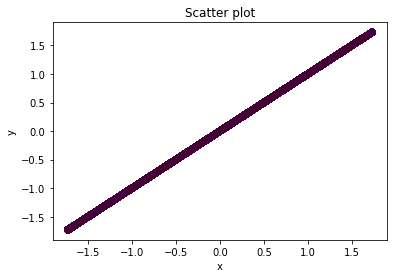

In [0]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']

# Plot
## purple points: "Normal"
## yellow points: "Outliers"
import matplotlib.pyplot as plt
plt.scatter(X_train[0], X_train[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [0]:
## Build the model
## using pyod
from pyod.models.auto_encoder import AutoEncoder
clf1 = AutoEncoder(hidden_neurons=[256,128,128,256], epochs=10, dropout_rate=0.5)
clf1.fit(X_train)


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 434)               188790    
_________________________________________________________________
dropout_43 (Dropout)         (None, 434)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 434)               188790    
_________________________________________________________________
dropout_44 (Dropout)         (None, 434)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 256)               111360    
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)             

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.5, epochs=10,
      hidden_activation='relu', hidden_neurons=[256, 128, 128, 256],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f1e6c47c2f0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

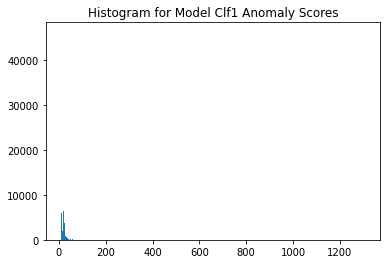

In [0]:
# Get the outlier scores for the train data
y_train_scores = clf1.decision_scores_  

# Predict the anomaly scores
y_test_scores = clf1.decision_function(x_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

# Plot it
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.show()

In [0]:
## summary statistics by cluster
import numpy as np
df_test = x_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<50, 0, 1)
df_test['cluster'].value_counts()

df_test.groupby('cluster').mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,score
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.024820,0.024820,0.02563,-0.001010,0.001418,-0.005096,-0.000464,0.005033,-0.005633,-0.005108,0.012898,-0.009178,-0.030065,-0.030647,-0.002814,-0.035531,0.005331,-0.029688,-0.027506,-0.034575,0.005719,-0.035637,-0.030681,-0.027360,-0.003947,-0.020912,0.011166,0.017212,0.024149,0.028240,0.020708,0.002236,-0.000274,-0.029247,-0.032789,0.034312,0.025479,0.003418,0.006687,-0.000242,...,-0.040061,-0.034930,-0.014463,-0.019151,-0.018304,-0.019160,-0.018924,-0.056199,0.023724,0.009463,0.022193,0.006973,-0.030981,0.036811,0.024545,0.015225,-0.022999,-0.002235,-0.002154,-0.017277,-0.005152,0.017552,-0.009122,0.003725,0.004356,0.017049,0.019122,0.010608,0.010190,-0.005736,-0.038694,0.054920,-0.057098,-0.041307,0.036288,-0.015901,-0.007896,-0.033799,-0.037616,14.775623
1,-0.878886,-0.878886,-0.90757,0.035753,-0.050228,0.180466,0.016444,-0.178210,0.199463,0.180870,-0.456742,0.324984,1.064631,1.085227,0.099643,1.258166,-0.188779,1.051275,0.974015,1.224316,-0.202508,1.261925,1.086419,0.968828,0.139758,0.740498,-0.395392,-0.609483,-0.855127,-0.999999,-0.733268,-0.079175,0.009720,1.035672,1.161083,-1.215018,-0.902220,-0.121041,-0.236792,0.008577,...,1.418593,1.236901,0.512137,0.678149,0.648168,0.678455,0.670103,1.990027,-0.840084,-0.335077,-0.785875,-0.246917,1.097069,-1.303489,-0.869166,-0.539119,0.814413,0.079150,0.076282,0.611785,0.182441,-0.621512,0.323031,-0.131900,-0.154241,-0.603713,-0.677135,-0.375647,-0.360832,0.203104,1.370193,-1.944749,2.021876,1.462710,-1.284980,0.563066,0.279597,1.196838,1.332026,64.050011


In [0]:
print(len(df_test['cluster']), len(x_test))

506691 506691


In [0]:
df_test['cluster'].to_csv('/content/drive/My Drive/datalab/IEEE_CIS_kaggle/predictions.csv')

In [0]:
def model_relu ():
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    #from keras.preprocessing import 

    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(434, )))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [0]:
def model_tanh ():
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    #from keras.preprocessing import 

    model = Sequential()
    model.add(Dense(64, activation='tanh', input_shape=(434, )))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [0]:
model = model_relu()

In [0]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               55680     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 55,809
Trainable params: 55,809
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
class_weight = {0:1., 1:100000.}
history = model.fit(X_train, y_train, epochs=10, batch_size=512, validation_split=0.3)

Train on 413378 samples, validate on 177162 samples
Epoch 1/10
413378/413378 [==============================] - 6s 14us/step - loss: 0.1560 - accuracy: 0.9641 - val_loss: 0.1923 - val_accuracy: 0.9654
Epoch 2/10
413378/413378 [==============================] - 6s 14us/step - loss: 0.1515 - accuracy: 0.9648 - val_loss: 0.2445 - val_accuracy: 0.9654
Epoch 3/10
413378/413378 [==============================] - 6s 14us/step - loss: 0.1518 - accuracy: 0.9648 - val_loss: 0.2559 - val_accuracy: 0.9654
Epoch 4/10
413378/413378 [==============================] - 6s 14us/step - loss: 0.1517 - accuracy: 0.9648 - val_loss: 0.2680 - val_accuracy: 0.9654
Epoch 5/10
413378/413378 [==============================] - 6s 14us/step - loss: 0.1513 - accuracy: 0.9648 - val_loss: 0.2931 - val_accuracy: 0.9654
Epoch 6/10
413378/413378 [==============================] - 6s 14us/step - loss: 0.1512 - accuracy: 0.9648 - val_loss: 0.3287 - val_accuracy: 0.9633
Epoch 7/10
413378/413378 [============================

In [0]:
history_dict = history.history

In [0]:
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

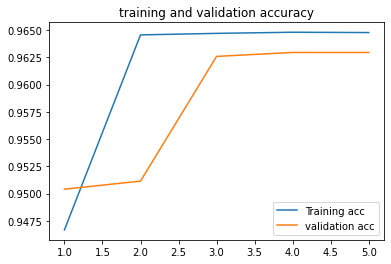

In [0]:
# plot acc
import matplotlib.pyplot as plt
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(history_dict['accuracy']) +1)

plt.plot(epochs, acc, label= 'Training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.title('training and validation accuracy')

plt.legend()

plt.show()

In [0]:
predictions = model.predict(x_test)

In [0]:
pred_class = model.predict_classes(x_test)

In [0]:
pred_class

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [0]:
pred_df = pd.DataFrame(pred_class)

In [0]:
pred_df.to_csv('/content/drive/My Drive/datalab/IEEE_CIS_kaggle/predictions.csv')

In [0]:
pred_df.head()

,0
0,0
1,0
2,0
3,0
4,0
